In [8]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [9]:
import tensorflow as tf
from tensorflow import lite

# Pre-processing of the images
We will be training a VGG-19 model on our custom training dataset to classify among the 5 categories-Phoma, Cescospora, Rust, Healthy, and Miners. The dataset must all be resized to the required dimension.

While resizing the images, let us also derive x_train,x_test,x_val,y_train,y_test and y_val hand-in-hand. These terms can be described in a nutshell as follows:

- **x_train**: Numpy arrays of the images of the training dataset
- **y_train**: Labels of the training dataset
- **x_test**: Numpy arrays of the images of the testing dataset
- **y_test**: Labels of the testing dataset
- **x_val**: Numpy arrays of the images of the validation dataset
- **y_val**: Labels of the validation dataset

In [10]:
train_path="./Dataset4/train"
test_path="./Dataset4/test"
val_path="./Dataset4/val"

In [11]:
IMG_SIZE = (128,128)

def is_img_empty(img):
  if type(img) is np.ndarray:
    if img.size == 0:
      return True
  if img is None:
    return True

def pre_proc_images(file_path):
    file_list=[]
    for folder in os.listdir(file_path):
        sub_path=file_path+"/"+folder
        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            if is_img_empty(img_arr):
              print(f'This file is corrupt, You must delete this file:\n{image_path}\n')
              continue
            img_arr=cv2.resize(img_arr,IMG_SIZE)
            file_list.append(img_arr)
    norm_file = np.array(file_list)/255.0
    return norm_file

def ImgDataGen(file_path):    
    file_datagen = ImageDataGenerator(rescale = 1./255)
    file_set = file_datagen.flow_from_directory(file_path,
                                                target_size = IMG_SIZE,
                                                batch_size = 32,
                                                class_mode = 'sparse')
    return file_set


In [12]:
train_x, test_x, val_x = pre_proc_images(train_path), pre_proc_images(test_path), pre_proc_images(val_path)

In [13]:
training_set, test_set, val_set = ImgDataGen(train_path), ImgDataGen(test_path), ImgDataGen(val_path)

Found 1636 images belonging to 5 classes.
Found 239 images belonging to 5 classes.
Found 465 images belonging to 5 classes.


In [14]:
train_y, test_y, val_y = training_set.classes, test_set.classes, val_set.classes

In [15]:
train_y.shape,test_y.shape,val_y.shape

((1636,), (239,), (465,))

In [16]:
train_x.shape,test_x.shape,val_x.shape

((1636, 128, 128, 3), (239, 128, 128, 3), (465, 128, 128, 3))

In [40]:
labels = [i for i in training_set.class_indices]

# Training using VGG 19

In [18]:
vgg = VGG16(input_shape= [128,128] + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 81s 1us/step


In [19]:
for layer in vgg.layers:
    layer.trainable = False

In [20]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(5, activation='softmax')(x)

In [21]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [22]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [24]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
52/52 [==============================] - 197s 4s/step - loss: 0.4629 - accuracy: 0.8521 - val_loss: 0.1913 - val_accuracy: 0.9484
Epoch 2/10
52/52 [==============================] - 198s 4s/step - loss: 0.1180 - accuracy: 0.9719 - val_loss: 0.1190 - val_accuracy: 0.9806
Epoch 3/10
52/52 [==============================] - 197s 4s/step - loss: 0.0717 - accuracy: 0.9908 - val_loss: 0.1060 - val_accuracy: 0.9828
Epoch 4/10
52/52 [==============================] - 184s 4s/step - loss: 0.0437 - accuracy: 0.9969 - val_loss: 0.0918 - val_accuracy: 0.9849
Epoch 5/10
52/52 [==============================] - 177s 3s/step - loss: 0.0315 - accuracy: 0.9969 - val_loss: 0.0843 - val_accuracy: 0.9849
Epoch 6/10
52/52 [==============================] - 203s 4s/step - loss: 0.0235 - accuracy: 0.9982 - val_loss: 0.0781 - val_accuracy: 0.9849
Epoch 7/10
52/52 [==============================] - 192s 4s/step - loss: 0.0204 - accuracy: 0.9994 - val_loss: 0.0739 - val_accuracy: 0.9849
Epoch 8/10
52

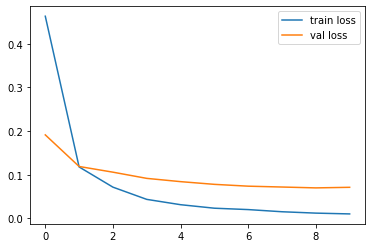

In [25]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

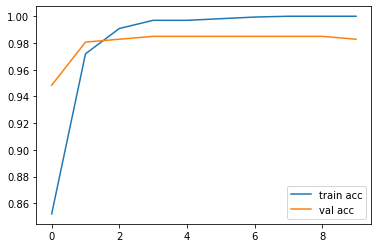

In [26]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [27]:
model.evaluate(test_x,test_y,batch_size=32)

8/8 [==============================] - 20s 2s/step - loss: 0.0686 - accuracy: 0.9791


[0.06860725581645966, 0.9790794849395752]

In [36]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
import numpy as np

In [29]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [30]:
accuracy_score(y_pred,test_y)

0.9790794979079498

In [31]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      0.99      0.99        78
           2       1.00      1.00      1.00        34
           3       1.00      0.95      0.97        73
           4       0.81      1.00      0.90        22

    accuracy                           0.98       239
   macro avg       0.96      0.99      0.97       239
weighted avg       0.98      0.98      0.98       239



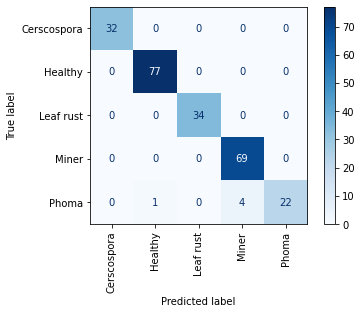

In [44]:
labels = [i for i in training_set.class_indices]
cm =confusion_matrix(test_y, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=labels)
disp.plot(cmap='Blues',xticks_rotation='vertical')
plt.show()


# Export the Model

In [33]:
keras_file = "Desease_control_model2.h5"
tf.keras.models.save_model(model,keras_file)
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

open("Desease_control_model2.tflite","wb").write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\ALIZAW~1\AppData\Local\Temp\tmpz_qpb54k\assets


59030532